In [15]:
import pandas as pd
import numpy as np
import torch
from transformers import BertTokenizer, BertModel
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import logging

In [16]:
# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

class BERTChatAnalyzer:
    def __init__(self, data, model_name='bert-base-uncased'):
        try:
            self.data = data.dropna(subset=['message']).reset_index(drop=True)
            # Load pre-trained BERT model and tokenizer
            self.tokenizer = BertTokenizer.from_pretrained(model_name)
            self.model = BertModel.from_pretrained(model_name)
            print(f"BERT model '{model_name}' loaded successfully.")
        except Exception as e:
            raise RuntimeError(f"Failed to load BERT model '{model_name}': {e}")

    def get_bert_embeddings(self, messages):
        '''Generate BERT embeddings for messages'''
        embeddings = []
        try:
            for message in messages:
                # Tokenize and encode messages
                inputs = self.tokenizer(message, return_tensors='pt', truncation=True, max_length=512, padding=True)

                # Generate embeddings
                with torch.no_grad():
                    outputs = self.model(**inputs)
                    # Use the [CLS] token embedding (first token)
                    embedding = outputs.last_hidden_state[0][0].numpy()
                    embeddings.append(embedding)
        except Exception as e:
            logging.error(f"Error generating BERT embeddings: {e}")
        
        return np.array(embeddings)
    
    def cluster_conversations(self, embeddings, n_clusters=5, random_state=42):
        '''Cluster conversation using K-means and visualize with t-SNE.'''
        try:
            # Dimensionality reduction for visualization
            tsne = TSNE(n_components=2, random_state=random_state)
            embeddings_2d = tsne.fit_transform(embeddings)

            # Clustering
            kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
            clusters = kmeans.fit_predict(embeddings)

            # Visualization
            plt.figure(figsize=(10, 8))
            scatter = plt.scatter(x=embeddings_2d[:, 0], y=embeddings_2d[:, 1], c=clusters, cmap='viridis')
            plt.title('Conversation Clusters')
            plt.colorbar(scatter)
            plt.show()
        except Exception as e:
            logging.error(f'Error in clustering or visualization: {e}')

        return clusters
    
    def analyze_conversation_semantic(self):
        '''Comprehensive BERT-based conversation analysis'''
        try:
            if 'message' not in self.data.columns:
                raise ValueError("Input data must contain a 'message' column.")
            
            # Generate embeddings
            logging.info("Generating BERT embeddings...")
            embeddings = self.get_bert_embeddings(self.data['message'])

            # Cluster conversations
            logging.info("Clustering conversations...")
            conversation_clusters = self.cluster_conversations(embeddings)

            # Add cluster information to DataFrame
            self.data['conversation_cluster'] = conversation_clusters

            # Calculate Silhouette Score
            logging.info("Calculating silhouette score...")
            silhouette_avg = silhouette_score(embeddings, conversation_clusters)

            # Cluster analysis
            cluster_analysis = self.data.groupby('conversation_cluster')['sender'].agg([
                ('unique_users', lambda x: x.nunique()),
                ('message_count', 'count')
            ])

            logging.info(f"Silhouette Score: {silhouette_avg}")

            return {
                'Embeddings': embeddings,
                'Clusters': conversation_clusters,
                'Cluster Analysis': cluster_analysis,
                'Silhouette Score': silhouette_avg
            }
        except Exception as e:
            raise RuntimeError(f'Error during conversation analysis: {e}')
    
    def export_to_csv(self, output_path):
        '''
        Export the updated data to a CSV file.
        output_path: Path to save the CSV file.
        '''
        self.data.to_csv(output_path, index=False)
        print(f'Updated data exported successfully to {output_path}')

2025-01-27 17:17:30,771 - INFO - Generating BERT embeddings...


BERT model 'bert-base-uncased' loaded successfully.


2025-01-27 17:24:55,834 - INFO - Clustering conversations...


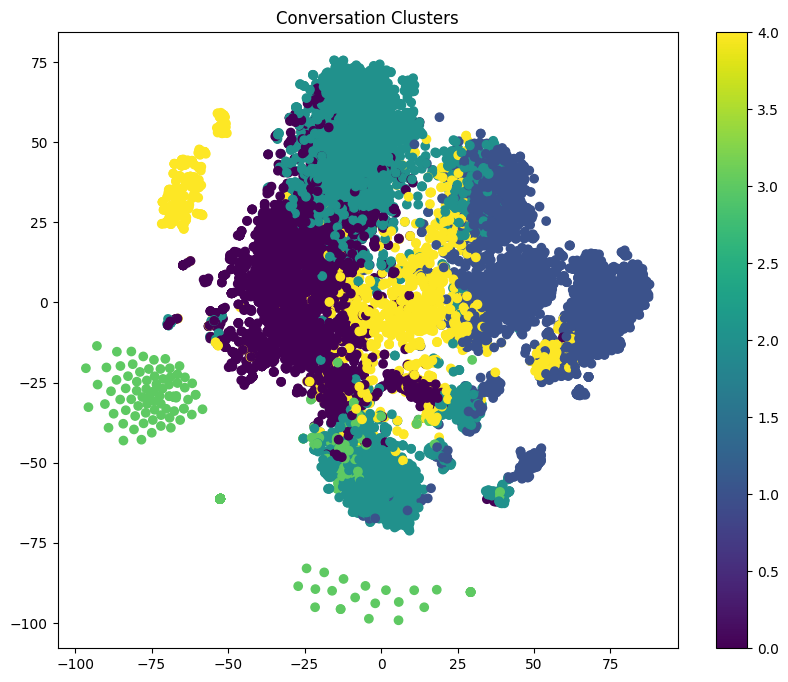

2025-01-27 17:25:41,828 - INFO - Calculating silhouette score...
2025-01-27 17:25:45,841 - INFO - Silhouette Score: 0.15501831471920013



 BERT Chat Analysis Results:

 Silhouette Score: 
 0.15501831471920013

 Cluster Analysis: 
                       unique_users  message_count
conversation_cluster                             
0                                4           2750
1                                4           2995
2                                4           3358
3                                4           1308
4                                4           1449
Updated data exported successfully to Whatsapp_Chat.csv


In [17]:
# Load the data
data = pd.read_csv('Whatsapp_Chat.csv')

# Initialize the BERT chat analyzer
bert_analyzer = BERTChatAnalyzer(data)

# Analyze 
bert_results = bert_analyzer.analyze_conversation_semantic()

# Print the results
if bert_results:
    print("\n BERT Chat Analysis Results:")
    print(f"\n Silhouette Score: \n {bert_results['Silhouette Score']}")
    print(f"\n Cluster Analysis: \n {bert_results['Cluster Analysis']}")

# Export updated data to CSV
bert_analyzer.export_to_csv('Whatsapp_Chat.csv')

**High-level Understanding (Plot Insights)**

1. **Conversation Clusters:** The plot shows several distinct clusters of chat messages, indicating that there are different conversation topics present in the group chat.

2. **Cluster Separation:** The clear separation between the clusters suggests that the conversations are quite distinct from each other in terms of their semantic content and communication patterns.

3. **Cluster Sizes:** The varying sizes of the clusters imply that some conversation topics or themes are more dominant than others in the overall chat history.

4. **Outliers:** The scattered individual points outside the main clusters could possibly represent unique or anomalous messages that don't fit well into the identified conversation themes.